# AOS_letter_simulate

A side notebook to `ingest_images_gen3.ipynb` , which fulfills the ticket https://jira.lsstcorp.org/browse/DM-29356 
    
Here we use `ts_phosim` to simulate input catalogs of stars arranged in a transpose-invariant shape, eg. letter F. 

I pull code from `epyc` : `AOS_sensor_outlines_arrows.ipynb`, and `analysisTools.py`, to keep everything in one place:
    


In [1]:
from lsst.ts.phosim.SkySim import SkySim
import numpy as np 
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
import matplotlib.pyplot as plt

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [2]:
mjd = 57648  # arbitrary observation date 
raInDeg = 0 # telescope pointing in degrees 
declInDeg = 0
rotSkyPos = 0 # rotation angle in degrees 
starMag = 15 # star magnitude 

(0.0, 4000.0)

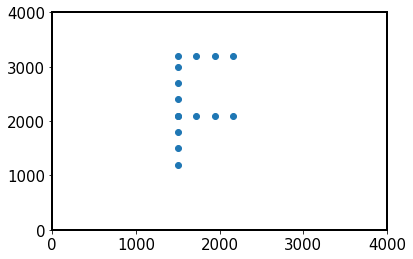

In [3]:
def pixel_letter_F(xmin=500,ymin=200,width=800,height=1200,xspacing=220,yspacing=200):
    xmax = xmin+width
    ymax = ymin+height
    # initialize array storing coords for all pixels 
    xPx = np.zeros(0)
    yPx = np.zeros(0)

    # middle horizontal line
    x_mid = np.arange(xmin,xmax,xspacing)
    y_mid = np.ones_like(x_mid) * ((ymin+ymax)/2.)
    xPx = np.append(xPx, x_mid)
    yPx = np.append(yPx, y_mid)
    
    # top horizontal line
    x_top = x_mid.copy()
    y_top = np.ones_like(x_top)*ymax
    xPx = np.append(xPx, x_top)
    yPx = np.append(yPx, y_top)

    # vertical line
    y_vert = np.arange(ymin+200,ymax-100,yspacing)
    x_vert = np.ones_like(y_vert)*xmin
    xPx = np.append(xPx, x_vert)
    yPx = np.append(yPx, y_vert)

    return xPx, yPx

%matplotlib inline
x,y  = pixel_letter_F(xmin=1500,ymin=1000,yspacing=300, height=2200 )
plt.scatter(x,y)
plt.xlim(0,4000)
plt.ylim(0,4000)

In [67]:
#skySim??

In [12]:
# Declare the SkySim()
skySim = SkySim()

# Set the observation information
skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos)

sensorName = ["R22_S00", "R22_S01","R22_S02",
              "R22_S10", "R22_S11","R22_S12",
              "R22_S20", "R22_S21","R22_S22"]

# add arrow per ComCam sensor (CCD)
xPx, yPx  = pixel_letter_F(xmin=1500,ymin=1000,yspacing=300, height=2200 )

store_x = []
store_y = []
starId = 0 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        starId += 1 
        
ra,dec = skySim.getRaDecInDeg()
mags = skySim.getStarMag()
coords_com = Table(data=[ra,dec, store_x,store_y,mags], 
             names=['ra','dec', 'xPx', 'yPx','g' ]  )

# add a column with object id 
coords_com['objid'] = np.arange(len(coords_com))


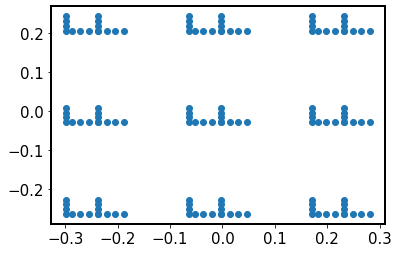

In [13]:
# center around 0 to show the input : 
ra = coords_com['ra']
ra[ra>180] = ra[ra>180]-360
plt.scatter(ra,coords_com['dec'],)


In [6]:
# save as the phosim catalog

import os

# NB:  here we only do 0.25 sec exposure to quickly test if the image is properly made 
# in generating large catalogs, change to 15 sec. 
def writePhosimHeader(output, ra, dec, camconfig=3, Opsim_filter=3, mjd=59580., exposure=0.25,
                     obsid=9006002, defocal=False):
    '''Write to file handle the phosim header'''
    output.write("Opsim_obshistid {}\n".format(obsid))
    output.write("Opsim_filter {}\n".format(Opsim_filter))
    output.write("mjd {}\n".format(mjd))
    output.write("SIM_SEED {}\n".format(1000))
    output.write("rightascension {}\n".format(ra))
    output.write("declination {}\n".format(dec))
    output.write("rotskypos {}\n".format(0.000000))
    output.write("rottelpos {}\n".format(0))
    output.write("SIM_VISTIME {}\n".format(exposure))
    output.write("SIM_NSNAP {}\n".format(1))
    output.write("moonphase {}\n".format(0.0))
    output.write("moonalt {}\n".format(-90))
    output.write("sunalt {}\n".format(-90))
    output.write("Opsim_rawseeing {}\n".format(-1))
    if defocal:
        output.write("move 10 -1500.0000\n") # write the defocal movement 
    output.write("camconfig {}\n".format(camconfig))

def writePhosimInstFile(catalog, ra, dec,  phosimFile="stars.inst", passband='r', outDir="./", camconfig=3, opd=False,
                        mjd=59580,exposure=.25, obsid=9006002, defocal=False,constMag=15. ):
    '''Generate a phosim instance catalog from a Pandas dataframe or Astropy Table '''
    
    passbands = {"u":"umeanpsfmag", 
                 "g":"gmeanpsfmag", 
                 "r":"rmeanpsfmag", 
                 "i":"imeanpsfmag", 
                 "z":"zmeanpsfmag", 
                 "y":"ymeanpsfmag", 
                }
    
    outFile = os.path.join(outDir, phosimFile)
    
    filterID = list(passbands.keys()).index(passband)
    with open(outFile,'w') as output:
        writePhosimHeader(output, ra, dec, camconfig=camconfig, Opsim_filter=filterID, mjd=mjd,
                         exposure=exposure, obsid=obsid, defocal=defocal)
        if (opd==True):
            output.write("opd 0 {} {} 500".format(ra,dec))
        else:
            for idx in range(len(catalog)):
                row = catalog[idx]
                output.write("object {} {} {} {} ../sky/sed_flat.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 12.0 none none\n".format(
                    int(row["objid"]),row["ra"],row["dec"], constMag))
    print('Saved as ', outFile)
    return outFile
                

In [7]:
writePhosimInstFile(coords_com,ra=raInDeg,dec=declInDeg, phosimFile='R22_letterF_30deg_rot.inst', 
                    outDir='/project/scichris/aos/images/comCam/',
                    passband='g', mjd=mjd, exposure=0.25, obsid=9006002, 
                    defocal=True,constMag=starMag )

Saved as  /project/scichris/aos/images/comCam/R22_letterF_30deg_rot.inst


'/project/scichris/aos/images/comCam/R22_letterF_30deg_rot.inst'

# Simulate letter F for lsstCam R22

Run phosim using this inst file and backgroundmode 0 : 

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 
    
    
    cd /project/scichris/aos/images/lsstCam

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/lsstCam/R22_letterF.inst -i lsst -e 1 -c /project/scichris/aos/images/lsstCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/lsstCam/letter_R22/raw/ > starPhoSimLetter.log 2>&1
    
    setup phosim_utils -r /project/scichris/aos/phosim_utils/

    phosim_repackager.py /project/scichris/aos/images/lsstCam/letter_R22/raw/ --out_dir /project/scichris/aos/images/lsstCam/letter_R22/repackaged/--inst lsst 
    

In [1]:
# show the postISR image 
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

path_to_repo = '/project/scichris/aos/images/lsstCam/letter_R22/DATA/'
butler = dafButler.Butler(path_to_repo)
registry = butler.registry



In [2]:
instrument = 'LSSTCam'
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )

expN = dataset.dataId["exposure"]

In [3]:
exposure = butler.get('postISRCCD', detector='R22_S02', instrument="LSSTCam",exposure=expN,
          collections=['run1'])

Text(0.5, 1.0, 'LSSTCam, R22_S02 (E2V)')

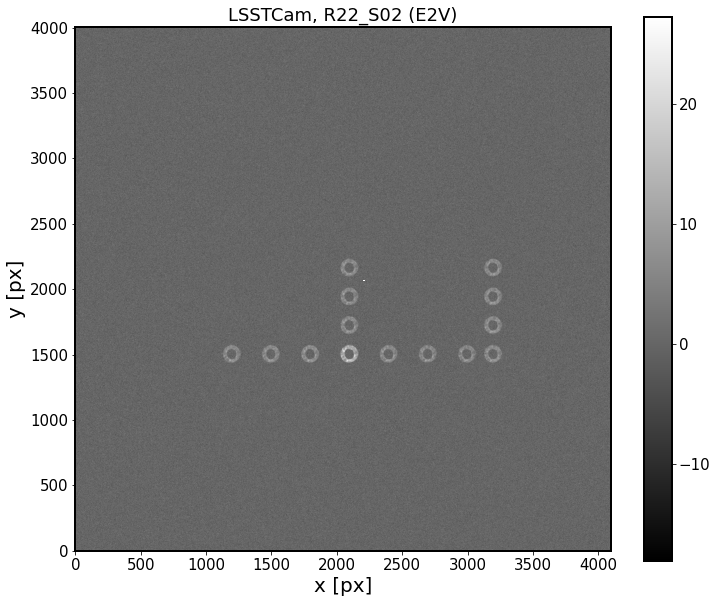

In [5]:
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
instrument = 'LSSTCam'

fig = plt.figure(figsize=(12, 10))
plt.imshow(data, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')
detector  = exposure.getDetector()
plt.title(f'{instrument}, {detector.getName()} ({detector.getSerial()[:3]})')

# Simulate letter F for  lsstComCam R22 

Use the same inst catalog for comcam (locations for R22 of lsstCam and comCam are almost identical ... )

    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 
    
    
    cd /project/scichris/aos/images/comCam

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/comCam/R22_letterF.inst -i comcam -e 1 -c /project/scichris/aos/images/comCam/noBkgnd.cmd -p 25 -o /project/scichris/aos/images/comCam/letter/raw/ > starPhoSimLetter.log 2>&1
    
    setup phosim_utils -r /project/scichris/aos/phosim_utils/

    phosim_repackager.py /project/scichris/aos/images/comCam/letter/raw/ --out_dir /project/scichris/aos/images/comCam/letter/repackaged/ --inst comcam 
    
    

Text(0.5, 1.0, 'LSSTComCam, R22_S02 (ITL)')

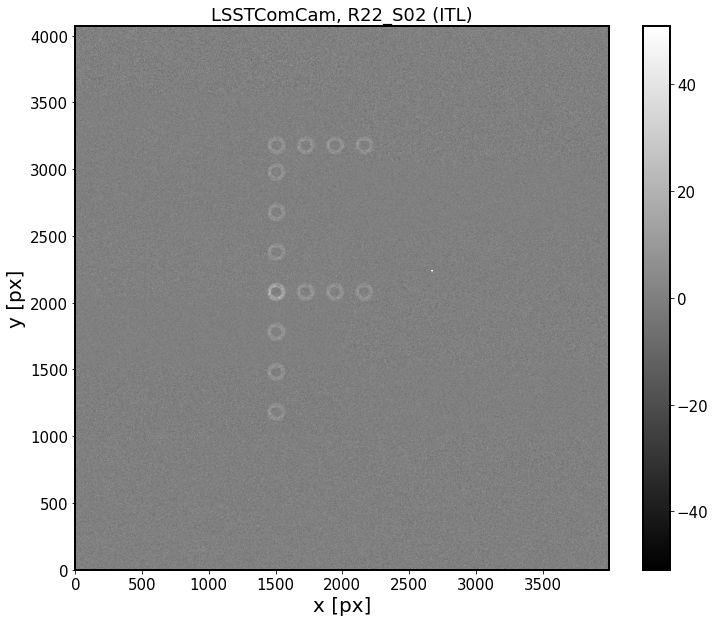

In [25]:
instrument = 'LSSTComCam'
path_to_repo = '/project/scichris/aos/images/comCam/letter/DATA/'
butler = dafButler.Butler(path_to_repo)


dataId0 = dict(instrument=instrument)
dataset = next(iter(butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['run1'],
                    dataId=dataId0  )))

expN = dataset.dataId["exposure"]
exposure = butler.get('postISRCCD', detector='R22_S02', 
                      instrument=instrument,exposure=expN,
          collections=['run1'])
detector  = exposure.getDetector()
data = exposure.image.array

vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(12, 10))
plt.imshow(data.T, origin='lower', vmin=vmin,vmax=vmax,cmap='gray')
plt.colorbar()
plt.xlabel('x [px]')
plt.ylabel('y [px]')

plt.title(f'{instrument}, {detector.getName()} ({detector.getSerial()[:3]})')

In [19]:
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/images/lsstCam/letter_R22/repackaged/MC_H_20160916_006002_R22_S00.fits')
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
EXPTIME =                 0.25                                                  
DARKTIME=                 0.25                                                  
RUNNUM  = '9006002 '                                                            
MJD-OBS =     57647.9999985532                                                  
DATE-OBS= '2016-09-16T23:59:59.875'                                             
DAYOBS  = '20160916'                                                            
DATE    = '2021-04-14T23:55:58'                                                 
MJD     =    59318.99719907407                                                  
FILTER  = 'g       '        

Plot with `cameraGeom.utils` : 

In [30]:

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


afwDisplay.setDefaultBackend("matplotlib")
repo_dir = os.path.join('/project/scichris/aos/images/comCam/letter/DATA/')

# need to specify the calib collections to be able to access the camera 
instrument = 'LSSTComCam'
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )
dataset = next(iter(
                    butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['run1'],
                    dataId=dict(instrument=instrument)  )))

# find out the exposure number 
expN = dataset.dataId["exposure"]

# get the exposure (contains the image, detectors, etc. )
exposure = butler.get('postISRCCD', detector='R22_S00', instrument=instrument,
          exposure=expN, collections=['run1'])


# I need to get the camera for cgUtils 
camera  = butler.get("camera", instrument=instrument, exposure=expN, 
                     )




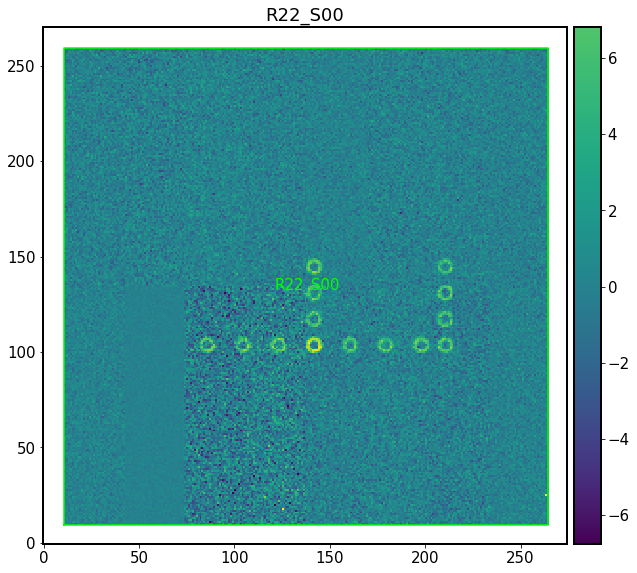

In [35]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.2, wspace=0.0, )

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=2)
#disp.scale('linear', 'minmax')
disp.setImageColormap('viridis' if True else 'gray')
dataType = "postISRCCD"

i = 1
detector = exposure.getDetector()

#for detector in camera:
    
ax = fig.add_subplot(1, 1, i)

mos = cameraGeomUtils.showCamera(camera,
                             cameraGeomUtils.ButlerImage(butler, dataType, 
                                                         instrument=instrument, 
                                                         exposure=expN,
                                                         verbose=True),
                             binSize=16, 
                             detectorNameList=[detector.getName()], 
                             display=disp, overlay=True,
                             title=detector.getName(),)
disp.show_colorbar(True)

#ax.axis("off")

i += 1 

In [36]:
cameraGeomUtils.showCamera?

Signature:
cameraGeomUtils.showCamera(
    camera,
    imageSource=<lsst.afw.cameraGeom.utils.FakeImageDataSource object at 0x7fd693fe8d30>,
    imageFactory=<class 'lsst.afw.image.image.ImageF'>,
    detectorNameList=None,
    binSize=10,
    bufferSize=10,
    overlay=True,
    title='',
    showWcs=None,
    ctype='green',
    textSize=1.25,
    originAtCenter=True,
    display=None,
    **kwargs,
)
Docstring:
Show a Camera on display, with the specified display.

The rotation of the sensors is snapped to the nearest multiple of 90 deg.
Also note that the pixel size is constant over the image array. The lower
left corner (LLC) of each sensor amp is snapped to the LLC of the pixel
containing the LLC of the image.

Parameters
----------
camera : `lsst.afw.cameraGeom.Camera`
    Camera object to use to make the image.
imageSource : `FakeImageDataSource` or `None`
    Source to get ccd images.  Must have a ``getCcdImage()`` method.
imageFactory : `lsst.afw.image.Image`
    Type of image